# Model Training and Evaluation

This notebook is dedicated to training, optimizing, and evaluating the model for predicting room occupancy. Steps included:

1. **Initial Model Training**:
   - Train an **XGBoost Classifier** using default hyperparameters to establish a baseline.
   - Evaluate the model on the validation set using **ROC AUC score**.

2. **Hyperparameter Optimization**:
   - Use **Random Search** (`RandomizedSearchCV`) to find the optimal set of hyperparameters for the XGBoost model.
   - The model is tuned to maximize **ROC AUC** using a parameter grid and cross-validation.

3. **Evaluation of the Optimized Model**:
   - Evaluate the **best model** obtained from Random Search using **accuracy**, **confusion matrix**, **classification report**, and **ROC Curve** to assess the performance.
   - **Save the trained model** using **joblib** for future use or deployment.

4. **Model Saving**:
   - Save the optimized XGBoost model in a serialized format (`xgb_occupancy_model.pkl`) for use in deployment.


## Import Required Libraries


In [18]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Model training and hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Model evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

# Saving the model
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns



## Load Preprocessed Datasets

In [19]:
# Assuming preprocessed datasets are saved in CSV format or available from the previous step
train_path = "../Dataset/Processed_data/processed_train.csv"
val_path = "../Dataset/Processed_data/processed_val.csv"
test_path = "../Dataset/Processed_data/processed_test.csv"

# Load preprocessed data
df_train_encoded = pd.read_csv(train_path)
df_val_encoded = pd.read_csv(val_path)
df_test_encoded = pd.read_csv(test_path)

# Get the union of columns across all datasets
all_columns = set(df_train_encoded.columns) | set(df_val_encoded.columns) | set(df_test_encoded.columns)

# Ensure each dataset has the same columns, adding missing ones with zeros
df_train_encoded = df_train_encoded.reindex(columns=all_columns, fill_value=0)
df_val_encoded = df_val_encoded.reindex(columns=all_columns, fill_value=0)
df_test_encoded = df_test_encoded.reindex(columns=all_columns, fill_value=0)

# Display first few rows of the train dataset to verify
print("Training Data with Unified Columns Across Datasets:")
display(df_train_encoded.head())



Training Data with Unified Columns Across Datasets:


,hour_2,month_4,hour_16,month_11,hour_4,hour_18,day_of_week_5,Light,hour_15,month_5,...,hour_21,Humidity,CO2,hour_12,hour_6,day_of_week_0,hour_17,hour_9,month_1,day_of_week_3
0,False,0.0,False,0.0,False,False,False,0.275490,False,0.0,...,False,0.470533,0.190933,False,False,False,True,False,0.0,False
1,False,0.0,False,0.0,False,False,False,0.277754,False,0.0,...,False,0.470332,0.186446,False,False,False,True,False,0.0,False
2,False,0.0,False,0.0,False,False,False,0.275490,False,0.0,...,False,0.469326,0.186136,False,False,False,True,False,0.0,False
3,False,0.0,False,0.0,False,False,False,0.275490,False,0.0,...,False,0.467315,0.182887,False,False,False,True,False,0.0,False
4,False,0.0,False,0.0,False,False,False,0.275490,False,0.0,...,False,0.467315,0.180566,False,False,False,True,False,0.0,False


## Train XGBoost Classifier


In [20]:

# Define the desired feature columns
desired_feature_columns = [
    'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
    'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
    'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
    'hour_22', 'hour_23', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 
    'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
    'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'
]

# Set the feature columns based on actual available columns in training data
feature_columns = [col for col in desired_feature_columns if col in df_train_encoded.columns]

# Use the defined feature columns for training and validation
X_train = df_train_encoded[feature_columns]
y_train = df_train_encoded['Occupancy']

X_val = df_val_encoded[feature_columns]
y_val = df_val_encoded['Occupancy']

# Define the XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Train the model on the training dataset
xgb_model.fit(X_train, y_train)





XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Predict on validation set


In [21]:
# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)
y_val_pred_prob = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate the model using ROC AUC
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Validation ROC AUC Score: {roc_auc:.2f}")

Validation ROC AUC Score: 0.99


## Hyperparameter Optimization : Random Search

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Random Search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up RandomizedSearchCV with XGBoost Classifier
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(eval_metric='auc', random_state=42),
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    scoring='roc_auc',  # Evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the Random Search on the training data
random_search.fit(X_train, y_train)

# Print the best parameters found by Random Search
print("Best Parameters found by Random Search:")
print(random_search.best_params_)

# Use the best estimator to predict on the validation set
best_model = random_search.best_estimator_
y_val_best_pred_prob = best_model.predict_proba(X_val)[:, 1]

# Evaluate using ROC AUC
best_roc_auc = roc_auc_score(y_val, y_val_best_pred_prob)
print(f"Validation ROC AUC Score with Best Hyperparameters: {best_roc_auc:.2f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=150, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.7s
[CV] END cols

## Save the Best-Trained Model

In [23]:
import joblib

# Define the path to save the best model
model_save_path = "../Models/xgb_occupancy_model.pkl"

# Save the trained model
joblib.dump(best_model, model_save_path)

print("Best trained XGBoost model saved successfully at:", model_save_path)



Best trained XGBoost model saved successfully at: ../Models/xgb_occupancy_model.pkl


## Summary of Model Training Results
- Best Hyperparameters found by Random Search.
- Validation ROC AUC Score for the best model.
- Confusion Matrix and Classification Report for detailed evaluation.


Best Hyperparameters found by Random Search:
{'subsample': 0.6, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

Validation ROC AUC Score with Best Hyperparameters: 0.99
Validation Accuracy Score: 0.98

Confusion Matrix:
[[1651   42]
 [ 122  850]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      1693
         1.0       0.95      0.87      0.91       972

    accuracy                           0.94      2665
   macro avg       0.94      0.92      0.93      2665
weighted avg       0.94      0.94      0.94      2665



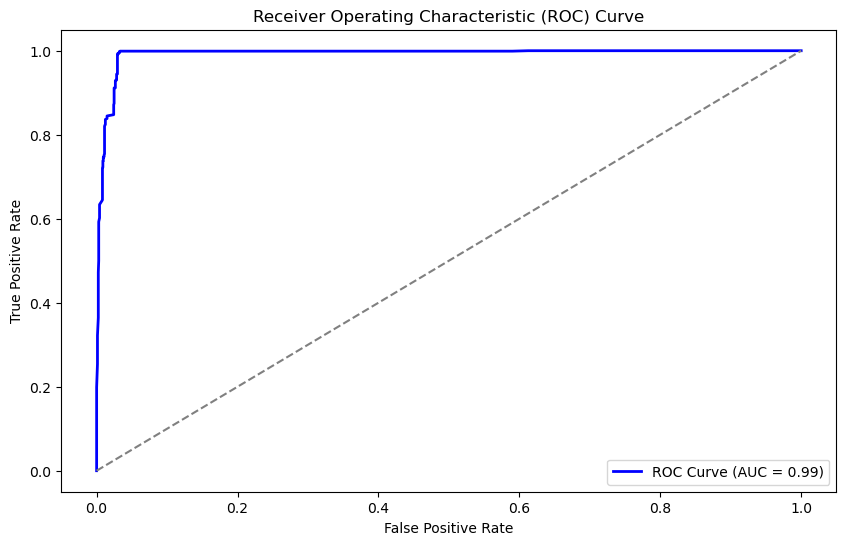

In [24]:
import matplotlib.pyplot as plt

# Print the best hyperparameters found by Random Search
print("Best Hyperparameters found by Random Search:")
print(random_search.best_params_)

# Calculate Validation ROC AUC Score with Best Hyperparameters
y_val_pred_prob = best_model.predict_proba(X_val)[:, 1]
best_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
print("\nValidation ROC AUC Score with Best Hyperparameters: {:.2f}".format(best_roc_auc))

# Calculate accuracy score
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy Score: {accuracy:.2f}")

# Generate and print the Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, best_model.predict(X_val)))

# Generate and print the Classification Report
print("\nClassification Report:")
print(classification_report(y_val, best_model.predict(X_val)))

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()